In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import CoxTime

from pycox.evaluation import EvalSurv
from pycox.models.cox_time import MLPVanillaCoxTime

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.transform(*get_target(df_test))
val = (x_test, y_test)

# Neural Network

In [10]:
in_features = x_train.shape[1]
num_nodes = [16,2]
out_features = 1
batch_norm = True
dropout = 0.5
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

model_cox = CoxTime(net, tt.optim.Adam(lr=0.01,amsgrad=True),labtrans=labtrans) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=(x_test,y_test), val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 0.7687,	val_loss: 0.6902
1:	[0s / 0s],		train_loss: 0.7088,	val_loss: 0.6899
2:	[0s / 0s],		train_loss: 0.7732,	val_loss: 0.6717
3:	[0s / 0s],		train_loss: 0.7132,	val_loss: 0.6534
4:	[0s / 0s],		train_loss: 0.6837,	val_loss: 0.6716
5:	[0s / 0s],		train_loss: 0.6786,	val_loss: 0.6652
6:	[0s / 0s],		train_loss: 0.6860,	val_loss: 0.6744
7:	[0s / 0s],		train_loss: 0.6773,	val_loss: 0.6565
8:	[0s / 0s],		train_loss: 0.6677,	val_loss: 0.6687
9:	[0s / 0s],		train_loss: 0.6641,	val_loss: 0.6480
10:	[0s / 0s],		train_loss: 0.6574,	val_loss: 0.6377
11:	[0s / 0s],		train_loss: 0.6465,	val_loss: 0.6381
12:	[0s / 0s],		train_loss: 0.6355,	val_loss: 0.6565
13:	[0s / 0s],		train_loss: 0.6535,	val_loss: 0.6310
14:	[0s / 0s],		train_loss: 0.6387,	val_loss: 0.6268
15:	[0s / 0s],		train_loss: 0.6437,	val_loss: 0.6170
16:	[0s / 0s],		train_loss: 0.6482,	val_loss: 0.6211
17:	[0s / 0s],		train_loss: 0.6505,	val_loss: 0.5792
18:	[0s / 0s],		train_loss: 0.6976,	val_loss: 0.6369
19:

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


0.7147255002565418

<Figure size 864x864 with 0 Axes>

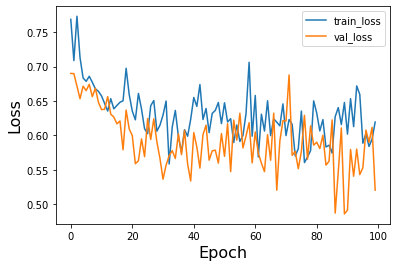

In [11]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, y_test[0], y_test[1], censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.26667178952423465

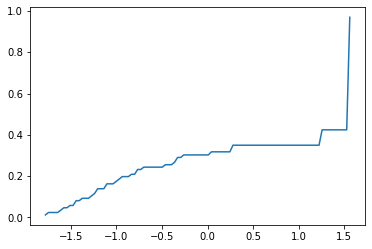

In [12]:
# extegrated_brier_score at all
time_grid = np.linspace(y_test[0].min(), y_test[0].max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [13]:
# c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


0.7412497756352727

0.3378802107950383

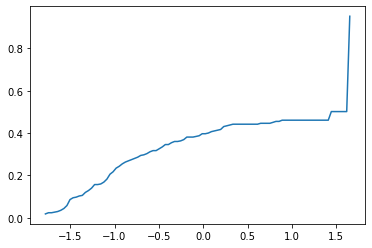

In [14]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

# Save

In [44]:
model_cox.save_model_weights('myweights_coxtime.pt')

# Bootstrap

In [16]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.7485413551330566. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.6566096544265747. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\

Bootstrap Internal validation:
The C-index:0.7429948024886732
The C-index Low 95% CI:0.7408914332120075
The C-index High 95% CI:0.745098171765339


In [17]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.47274649143219. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.5340341329574585. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


Bootstrap External validation:
The C-index:0.7192771008427058
The C-index Low 95% CI:0.716518726317021
The C-index High 95% CI:0.7220354753683906


# LASSO var

In [18]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [19]:
# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


x_train = x_mapper.fit_transform(df_train_lasso).astype('float32')
x_test = x_mapper.transform(df_test_lasso).astype('float32')

val = (x_test, y_test)

In [24]:
in_features = x_train.shape[1]
num_nodes = [8,2]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

model_cox = CoxTime(net, tt.optim.Adam(lr=0.01,amsgrad=True),labtrans=labtrans) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=(x_test,y_test), val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 0.7133,	val_loss: 0.6968
1:	[0s / 0s],		train_loss: 0.7414,	val_loss: 0.6922
2:	[0s / 0s],		train_loss: 0.6994,	val_loss: 0.6805
3:	[0s / 0s],		train_loss: 0.6842,	val_loss: 0.6841
4:	[0s / 0s],		train_loss: 0.7024,	val_loss: 0.6882
5:	[0s / 0s],		train_loss: 0.6831,	val_loss: 0.6696
6:	[0s / 0s],		train_loss: 0.6806,	val_loss: 0.6741
7:	[0s / 0s],		train_loss: 0.6709,	val_loss: 0.6758
8:	[0s / 0s],		train_loss: 0.6862,	val_loss: 0.6732
9:	[0s / 0s],		train_loss: 0.6834,	val_loss: 0.6523
10:	[0s / 0s],		train_loss: 0.6882,	val_loss: 0.6669
11:	[0s / 0s],		train_loss: 0.6743,	val_loss: 0.6639
12:	[0s / 0s],		train_loss: 0.6820,	val_loss: 0.6778
13:	[0s / 0s],		train_loss: 0.6762,	val_loss: 0.6803
14:	[0s / 0s],		train_loss: 0.6863,	val_loss: 0.6738
15:	[0s / 0s],		train_loss: 0.6611,	val_loss: 0.6646
16:	[0s / 0s],		train_loss: 0.6587,	val_loss: 0.6665
17:	[0s / 0s],		train_loss: 0.6755,	val_loss: 0.6730
18:	[0s / 0s],		train_loss: 0.6576,	val_loss: 0.6488
19:

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


0.6952283222165213

<Figure size 864x864 with 0 Axes>

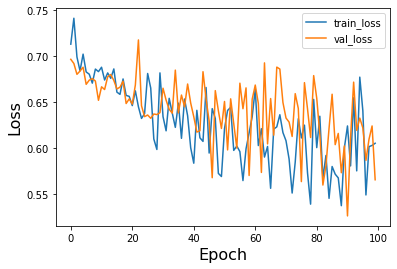

In [25]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, y_test[0], y_test[1], censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.265515523968501

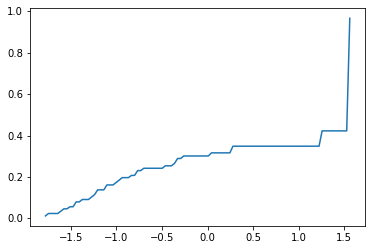

In [26]:
# extegrated_brier_score at all
time_grid = np.linspace(y_test[0].min(), y_test[0].max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [27]:
# Internal:c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0,  status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


0.7312751609015615

0.33750835958780445

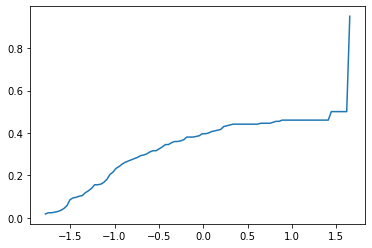

In [28]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [29]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.7485413551330566. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.6566096544265747. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\

Bootstrap Internal validation:
The C-index:0.7333146214566673
The C-index Low 95% CI:0.7311008068219296
The C-index High 95% CI:0.735528436091405


In [30]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.47274649143219. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


Bootstrap External validation:
The C-index:0.6995017067424245
The C-index Low 95% CI:0.696816651700245
The C-index High 95% CI:0.702186761784604


# TNM

In [31]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [32]:
# to standardize and get dependent variables 
cols_leave = ['T', 'N', 'M', 'Stage'] #categorical variables 

leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(leave)


x_train = x_mapper.fit_transform(df_train_tnm).astype('float32')
x_test = x_mapper.transform(df_test_tnm).astype('float32')

val = (x_test, y_test)

In [37]:
in_features = x_train.shape[1]
num_nodes = [8,8]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

model_cox = CoxTime(net, tt.optim.Adam(lr=0.01,amsgrad=True),labtrans=labtrans) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=(x_test,y_test), val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 0.7673,	val_loss: 0.7020
1:	[0s / 0s],		train_loss: 0.7433,	val_loss: 0.6932
2:	[0s / 0s],		train_loss: 0.7154,	val_loss: 0.6853
3:	[0s / 0s],		train_loss: 0.7544,	val_loss: 0.6713
4:	[0s / 0s],		train_loss: 0.7056,	val_loss: 0.6846
5:	[0s / 0s],		train_loss: 0.6798,	val_loss: 0.6428
6:	[0s / 0s],		train_loss: 0.6962,	val_loss: 0.6290
7:	[0s / 0s],		train_loss: 0.6754,	val_loss: 0.6677
8:	[0s / 0s],		train_loss: 0.6385,	val_loss: 0.6629
9:	[0s / 0s],		train_loss: 0.6938,	val_loss: 0.6240
10:	[0s / 0s],		train_loss: 0.6286,	val_loss: 0.6390
11:	[0s / 0s],		train_loss: 0.6157,	val_loss: 0.6630
12:	[0s / 0s],		train_loss: 0.6262,	val_loss: 0.6368
13:	[0s / 0s],		train_loss: 0.6087,	val_loss: 0.6229
14:	[0s / 0s],		train_loss: 0.6277,	val_loss: 0.6071
15:	[0s / 0s],		train_loss: 0.6531,	val_loss: 0.6782
16:	[0s / 0s],		train_loss: 0.5663,	val_loss: 0.6336
17:	[0s / 0s],		train_loss: 0.5888,	val_loss: 0.6235
18:	[0s / 0s],		train_loss: 0.6882,	val_loss: 0.6529
19:

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


0.668291431503335

<Figure size 864x864 with 0 Axes>

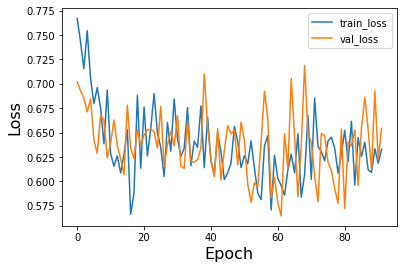

In [38]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, y_test[0], y_test[1], censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.2373424388645863

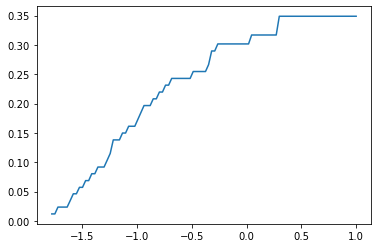

In [39]:
# extegrated_brier_score at all
time_grid = np.linspace(y_test[0].min(), y_test[1].max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [40]:
# Internal:c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


0.6685684248314059

0.3392111789034071

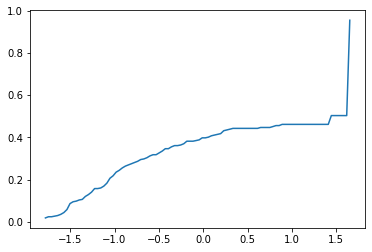

In [41]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [42]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.779185175895691. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.7485413551330566. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\site-packages\pycox\utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -1.5953218936920166. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "
C:\Users\liwei\anaconda3\lib\

Bootstrap Internal validation:
The C-index:0.671759354448679
The C-index Low 95% CI:0.6692346710750567
The C-index High 95% CI:0.6742840378223012


In [43]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6720112706643265
The C-index Low 95% CI:0.6692342793189809
The C-index High 95% CI:0.6747882620096721
